In [1]:
%pylab inline
import pymc3 as pm
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The model:

$p(y, x_n) = \text{Normal}(y \mid 0, 3) \times \displaystyle\prod_{n=1}^{9} \text{Normal}(x_n \mid 0, \text{exp}(y / 2))$

In [2]:
nd = 9

In [3]:
# compute log density
nres = 500
xval = np.linspace(-20, 20, nres)
yval = np.linspace(-9, 9, nres)
xv, yv = np.meshgrid(xval, yval)

# formally it need marginalization if nd > 1
logp_2d = st.norm.logpdf(yv, loc=0., scale=3.) +\
    st.norm.logpdf(xv, loc=0., scale=np.exp(yv/2))

In [4]:
# forward random
nsample = 10000
yr = st.norm.rvs(loc=0., scale=3., size=nsample)
xnr = st.norm.rvs(loc=0., scale=np.exp(yr/2), size=(nd, nsample))

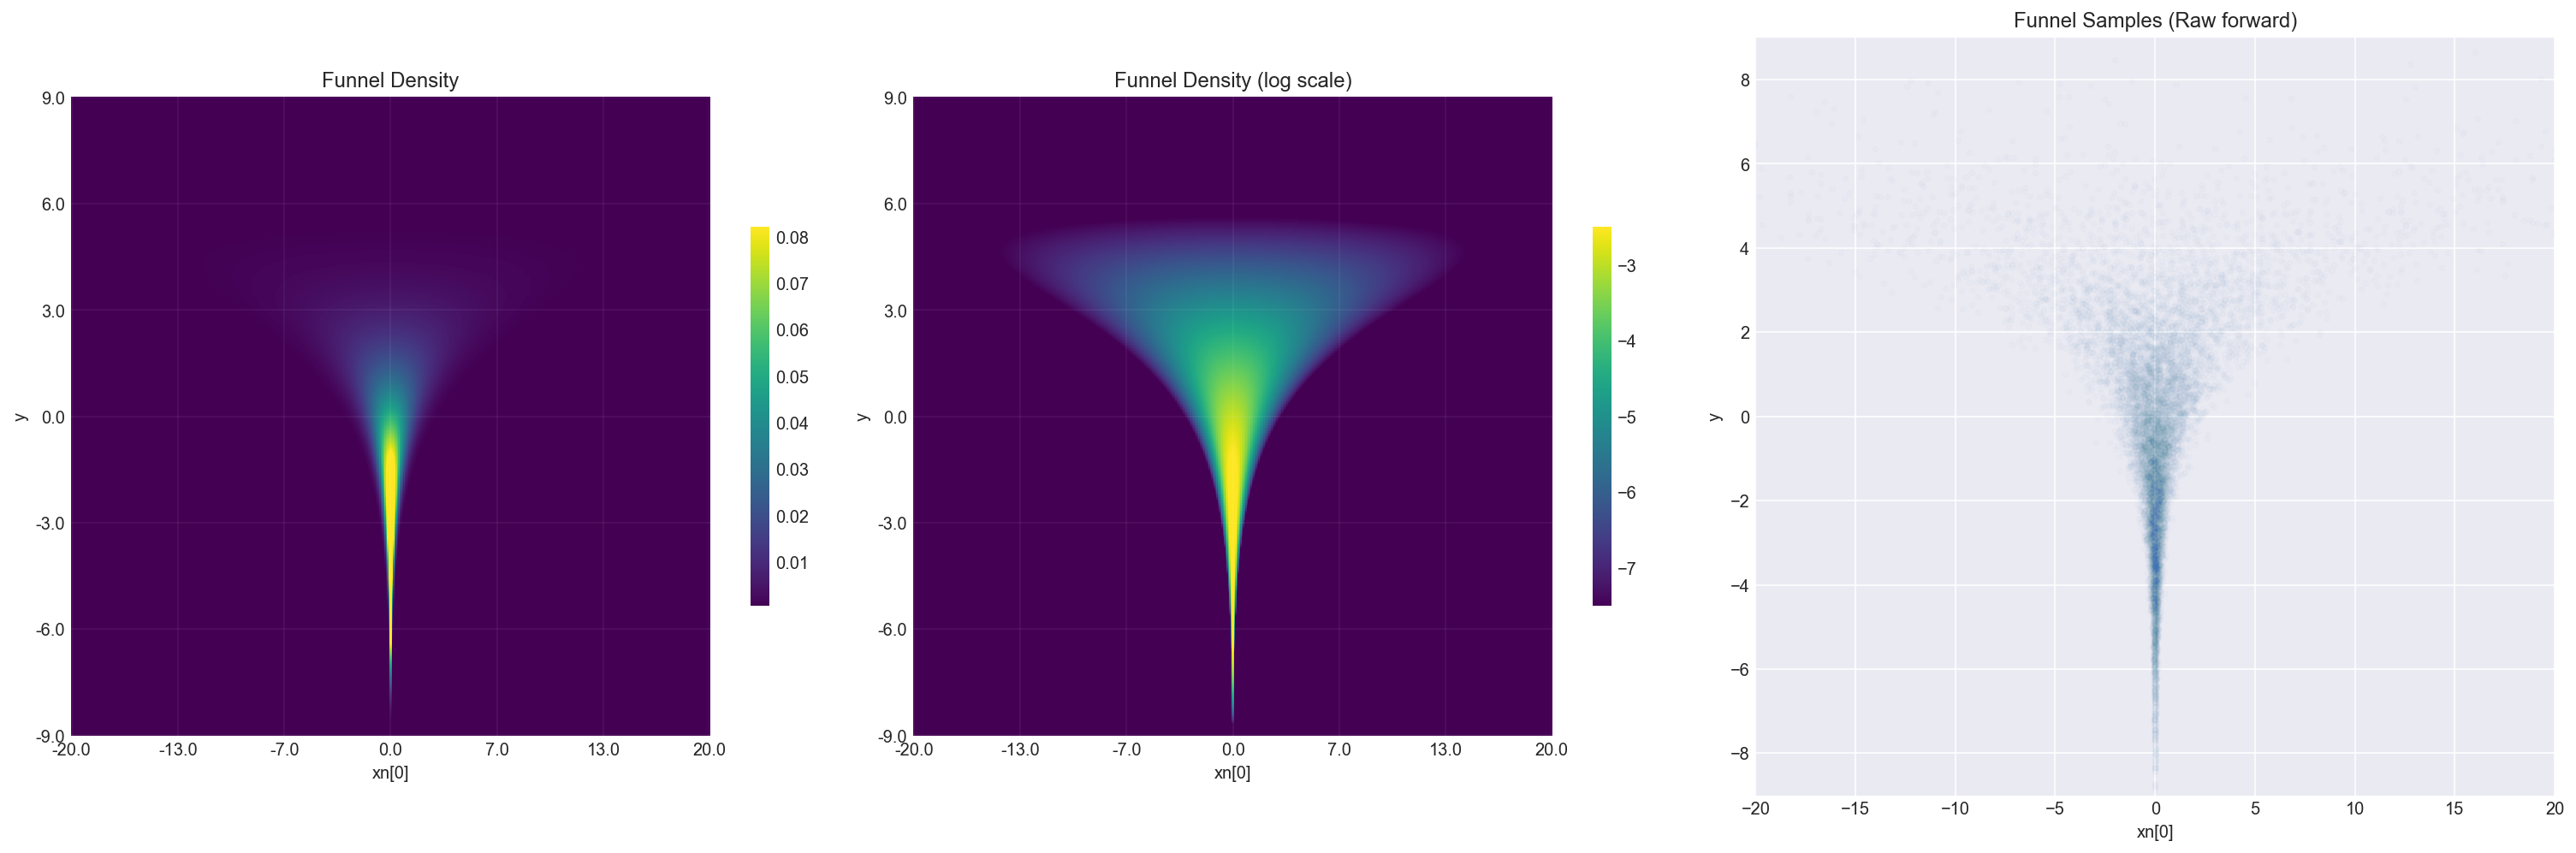

In [5]:
def show_logp2d(logp_2d, ax, func = lambda x: x):
    img = ax.imshow(func(logp_2d), 
                     vmin=func(-7.5), vmax=func(-2.5), 
                     cmap='viridis', origin='lower')
    ax.grid(color='w', linestyle='-', linewidth=1, alpha=.05)
    ax.set_yticks(np.linspace(0, 499, 7))
    ax.set_yticklabels(np.linspace(-9, 9, 7).round())
    ax.set_xticks(np.linspace(0, 499, 7))
    ax.set_xticklabels(np.linspace(-20, 20, 7).round())
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    plt.colorbar(img, ax=ax, shrink=.5)
    return ax

def show_sample2d(xnr, yr, ib, ax):
    ax.scatter(xnr[ib], yr, marker='.', alpha=.01)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-9, 9)
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    return ax

ib = 0
_, ax = plt.subplots(1, 3, figsize=(21, 7))
show_logp2d(logp_2d, ax[0], np.exp)
ax[0].set_title('Funnel Density')
show_logp2d(logp_2d, ax[1])
ax[1].set_title('Funnel Density (log scale)')
show_sample2d(xnr, yr, ib, ax[2])
ax[2].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

In [6]:
with pm.Model() as m_raw:
    y_ = pm.Normal('y', mu=0., sd=3.)
    x_ = pm.Normal('x', mu=0., sd=pm.math.exp(y_/2), shape=nd)
    trace = pm.sample(nsample, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, y]
100%|██████████| 12000/12000 [00:41<00:00, 288.03it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6348961833875925, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


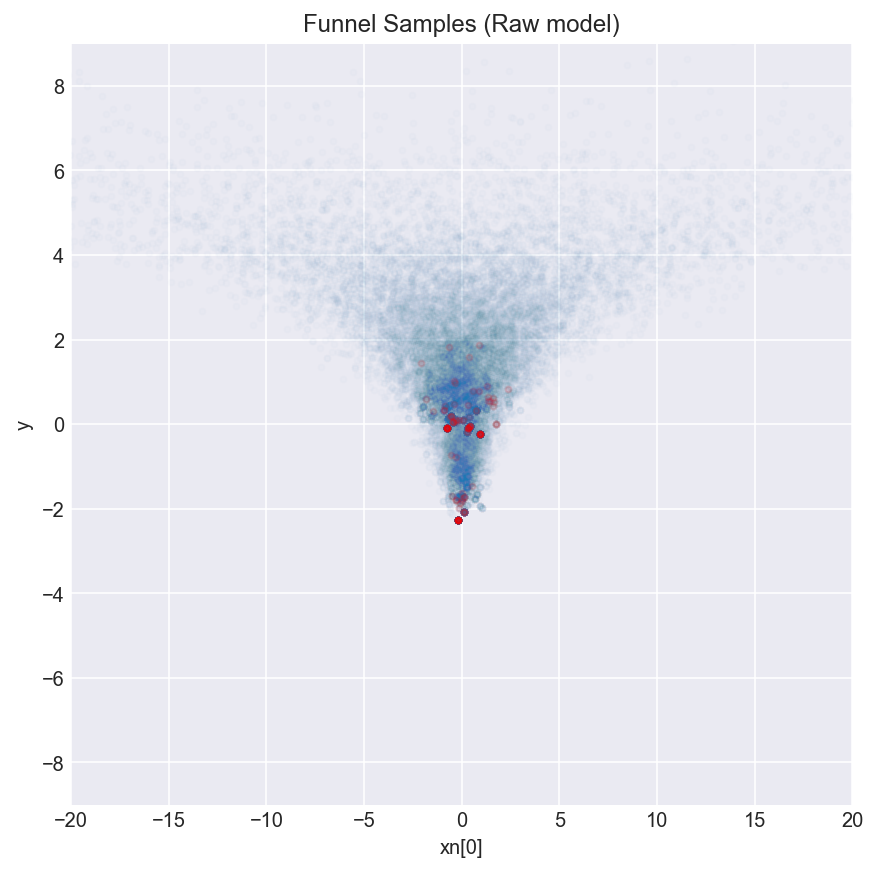

In [7]:
divg = trace.get_sampler_stats('diverging')

_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace['x'].T, trace['y'], ib, ax)
ax.scatter(trace['x'][divg, ib], trace['y'][divg], marker='.', color='r', alpha=.1)
ax.set_title('Funnel Samples (Raw model)');

In [8]:
with pm.Model() as m_tran:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    trace2 = pm.sample(nsample, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 12000/12000 [00:31<00:00, 385.45it/s]


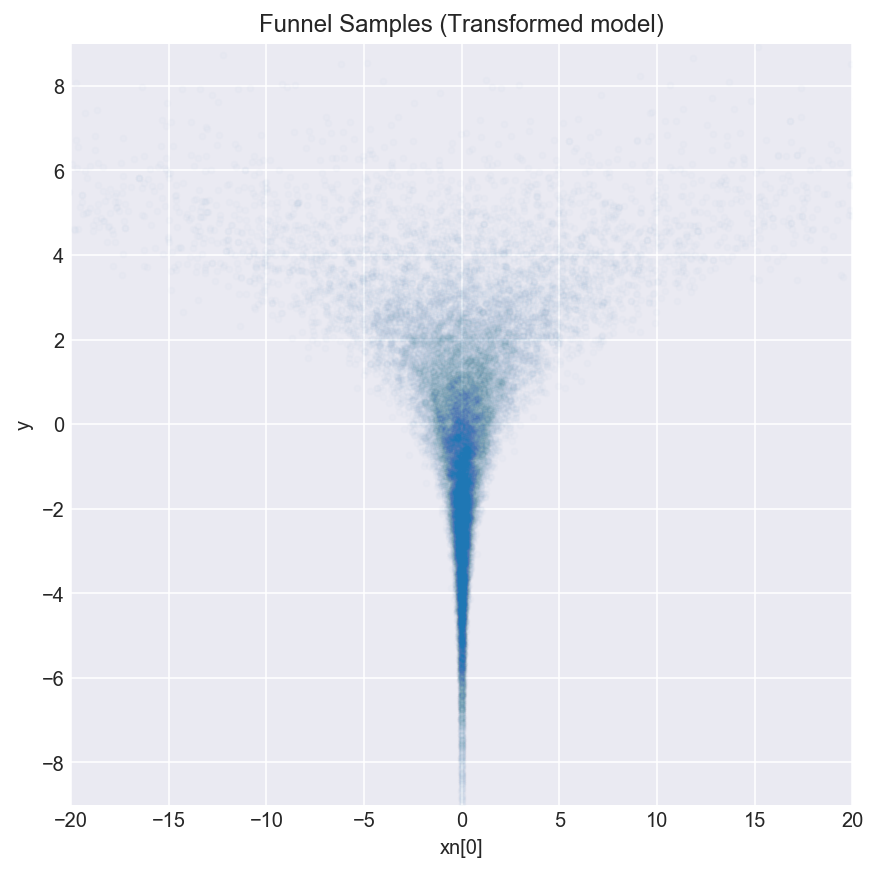

In [9]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace2['x'].T, trace2['y'], ib, ax)
ax.set_title('Funnel Samples (Transformed model)');

In [10]:
yr2 = st.norm.rvs(loc=0., scale=1., size=nsample) * 3.
xnr2 = st.norm.rvs(loc=0., scale=1., size=(nd, nsample)) * np.exp(yr2/2)

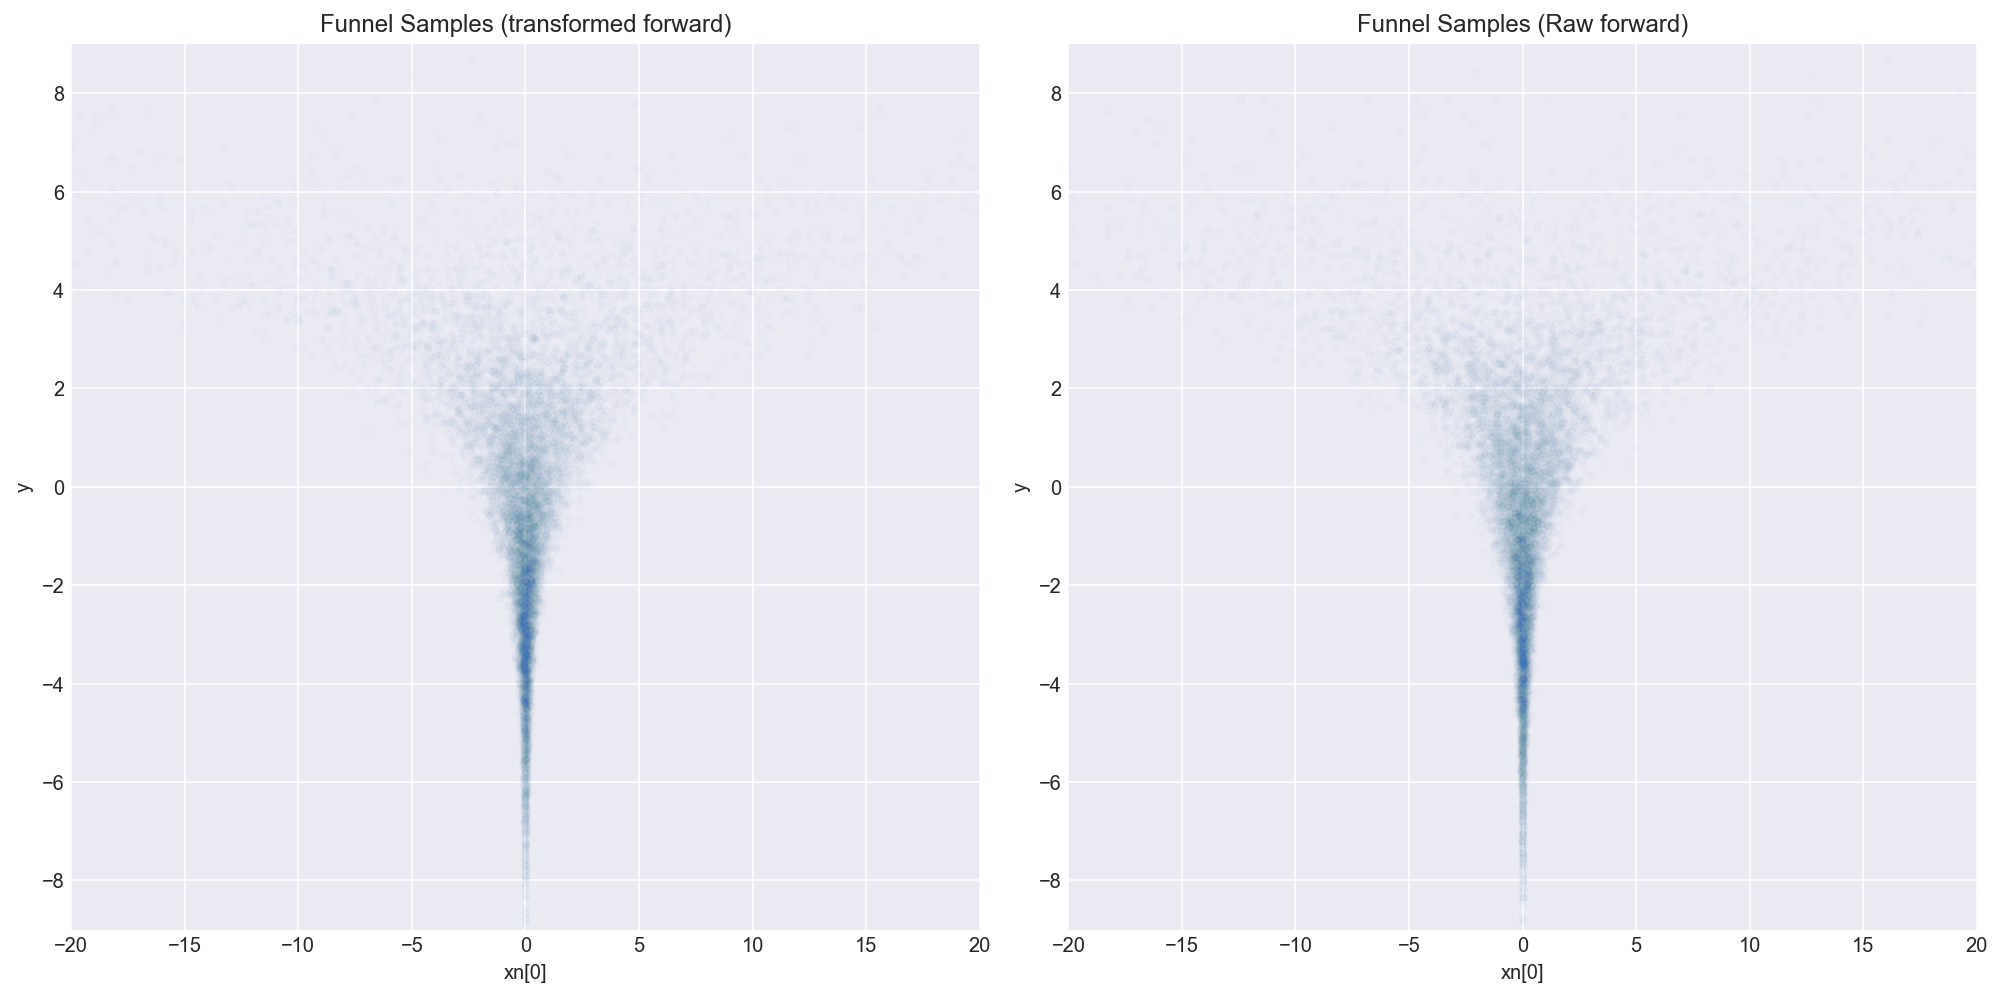

In [11]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))
show_sample2d(xnr2, yr2, ib, ax[0])
ax[0].set_title('Funnel Samples (transformed forward)')
show_sample2d(xnr, yr, ib, ax[1])
ax[1].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

# Measure-preserving transformation

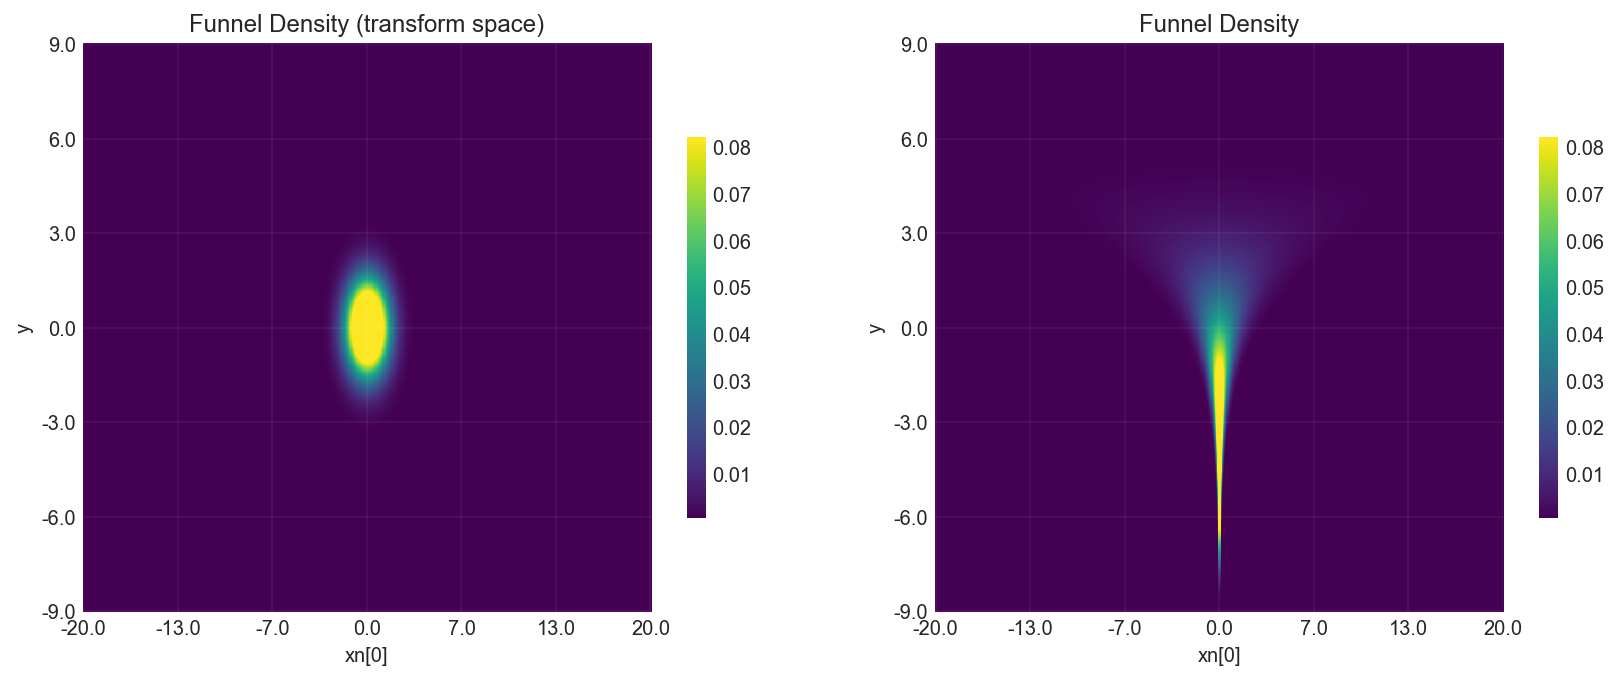

In [12]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))
logp_2d_t = st.norm.logpdf(yv, loc=0., scale=1.) +\
    st.norm.logpdf(xv, loc=0., scale=1.)
show_logp2d(logp_2d_t, ax[0], np.exp)
ax[0].set_title('Funnel Density (transform space)')
show_logp2d(logp_2d, ax[1], np.exp)
ax[1].set_title('Funnel Density');

# nres2 = 50
# xval2 = np.linspace(-20, 20, nres2)
# yval2 = np.linspace(-9, 9, nres2)
# xv2, yv2 = np.meshgrid(xval2, yval2)
# V = yv2 * 3.
# U = xv2 * np.exp(V/2.)
# M = st.norm.logpdf(yv2, loc=0., scale=1.) +\
#     st.norm.logpdf(xv2, loc=0., scale=1.)
# Q = ax[2].quiver(xv2, yv2, U, V, M, units='x',  width=0.05,
#                scale=1/.25, cmap='viridis');

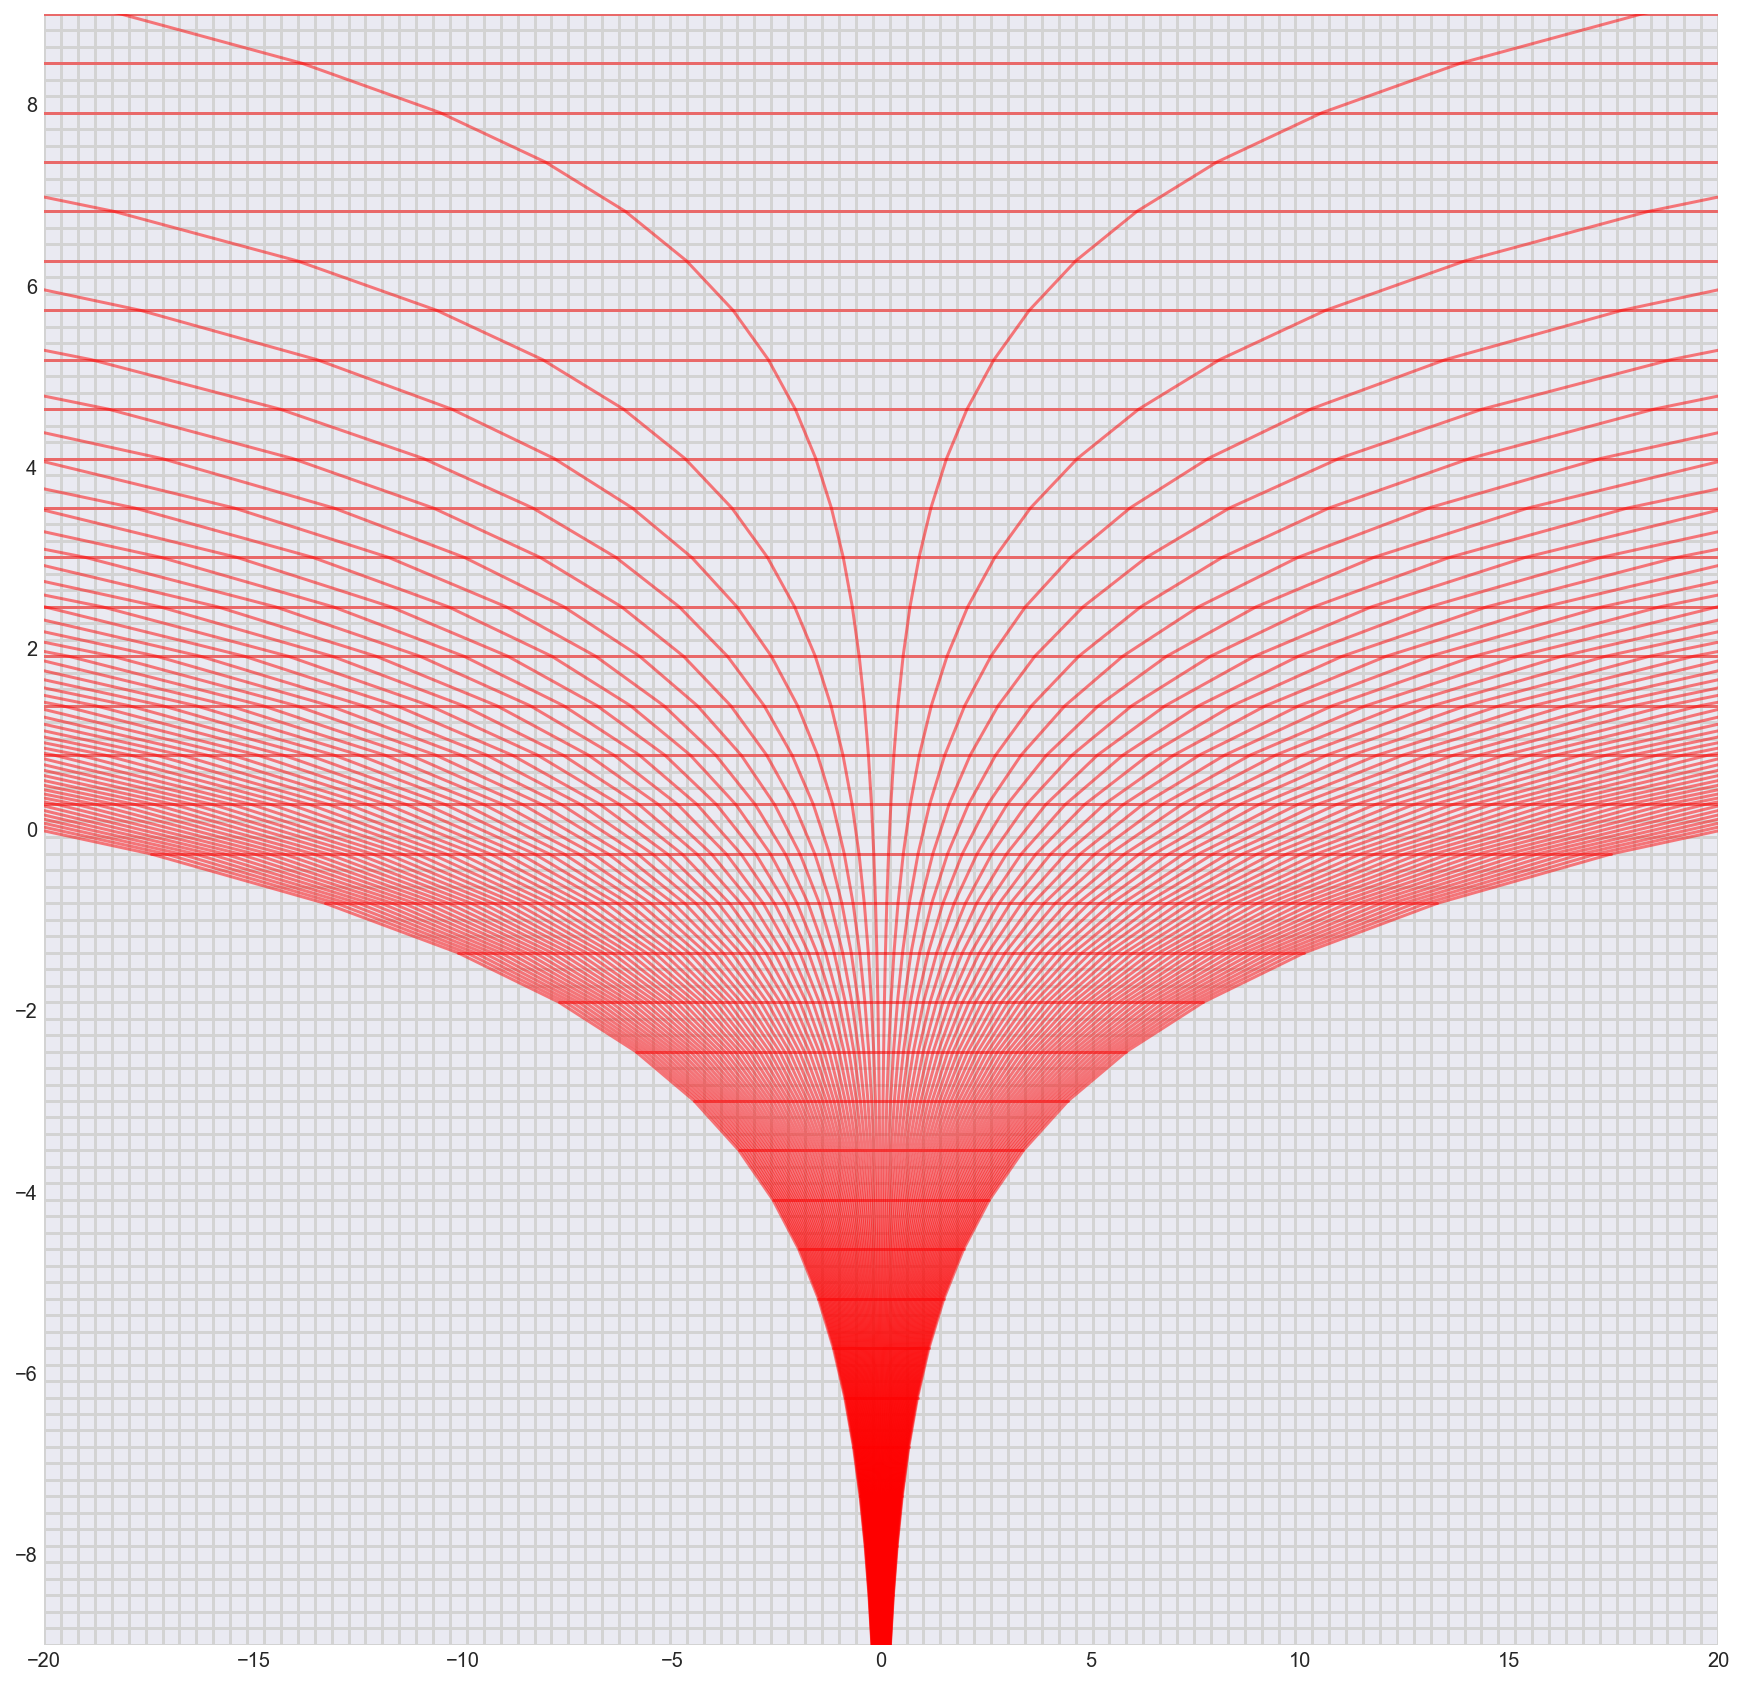

In [13]:
def plot_grid(ax, gridx, gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i, :], gridy[i, :], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:, i], gridy[:, i], **kwargs)
    ax.grid('off')


def f(x, y): return (np.exp(y*3/2.) * x, y*3.)


_, ax = plt.subplots(1, 1, figsize=(15, 15))

nres2 = 100
xval2 = np.linspace(-20, 20, nres2)
yval2 = np.linspace(-9, 9, nres2)
xv2, yv2 = np.meshgrid(xval2, yval2)
plot_grid(ax, xv2, yv2, color="lightgrey")

distx, disty = f(xv2, yv2)
plot_grid(ax, distx, disty, color="r", alpha=.5)

ax.set_xlim(-20, 20)
ax.set_ylim(-9, 9);

In [14]:
pt = m_raw.test_point
pt

{'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y': array(0.)}

In [15]:
# you can varify that the logp is not really the same
logp_ref = lambda x, y: st.norm.logpdf(y, loc=0., scale=3.) +\
    st.norm.logpdf(x, loc=0., scale=np.exp(y/2)).sum()
print('The sum(logp) of the test point is {}'.format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'.format(m_raw.logp(pt)))

The sum(logp) of the test point is -10.287997620714837
Compute sum(logp) using the model: -10.287997620714835


In [16]:
m_tran.test_point

{'x_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y_raw': array(0.)}

In [17]:
def forward_point(point):
    pt = point
    pt['y'] = point['y_raw']*3.
    pt['x'] = point['x_raw']*np.exp(pt['y']/2)
    return pt

def inverse_point(point):
    pt = point
    pt['y_raw'] = point['y']/3.
    pt['x_raw'] = point['x']/np.exp(point['y']/2)
    return pt

In [18]:
print('Compute sum(logp) using the transformed model: {}'.format(m_tran.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model: -9.189385332046724


In [19]:
pt['y'] = -3.
print('The sum(logp) of the test point is {}'
      .format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'
      .format(m_raw.logp(pt)))
print('Compute sum(logp) using the transformed model: {}'
      .format(m_tran.logp(inverse_point(pt))))

The sum(logp) of the test point is 2.712002379285164
Compute sum(logp) using the model: 2.7120023792851637
Compute sum(logp) using the transformed model: -9.689385332046724


In [20]:
with pm.Model() as m_tran_withjac:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    
    pm.Potential('pot', np.log(1/3)+pm.math.log(pm.math.abs_(pm.math.exp(-y_/2)))*nd)

In [21]:
print('Compute sum(logp) using the transformed model with correct jacobian_det: {}'
      .format(m_tran_withjac.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model with correct jacobian_det: 2.712002379285167


In [22]:
pt['y'] = st.norm.rvs(loc=0., scale=3.)
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))
print('The sum(logp) of the test point is {}'
      .format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'
      .format(m_raw.logp(pt)))
print('Compute sum(logp) using the transformed model 2: {}'
      .format(m_tran_withjac.logp(inverse_point(pt))))

The sum(logp) of the test point is 4.294031861475906
Compute sum(logp) using the model: 4.294031861475904
Compute sum(logp) using the transformed model 2: 4.294031861475904


Additional validation of jacobian determinant

In [23]:
logp_ref1 = lambda x, y: st.norm.logpdf(y, loc=0., scale=3.) +\
    st.norm.logpdf(x, loc=0., scale=np.exp(y/2))

logp_ref2 = lambda x, y: st.norm.logpdf(y/3., loc=0., scale=1.) +\
    st.norm.logpdf(x/np.exp(y/2), loc=0., scale=1.) +\
    np.log(1/3)+\
    np.log(np.abs(np.exp(-y/2)))

xtest = st.norm.rvs(loc=0., scale=1.)
ytest = st.norm.rvs(loc=0., scale=1.)

print('The sum(logp) of the test point is {}'
      .format(logp_ref1(xtest, ytest)))
print('The sum(logp) of the test point is {}'
      .format(logp_ref2(xtest, ytest)))

The sum(logp) of the test point is -4.810231247825546
The sum(logp) of the test point is -4.810231247825546


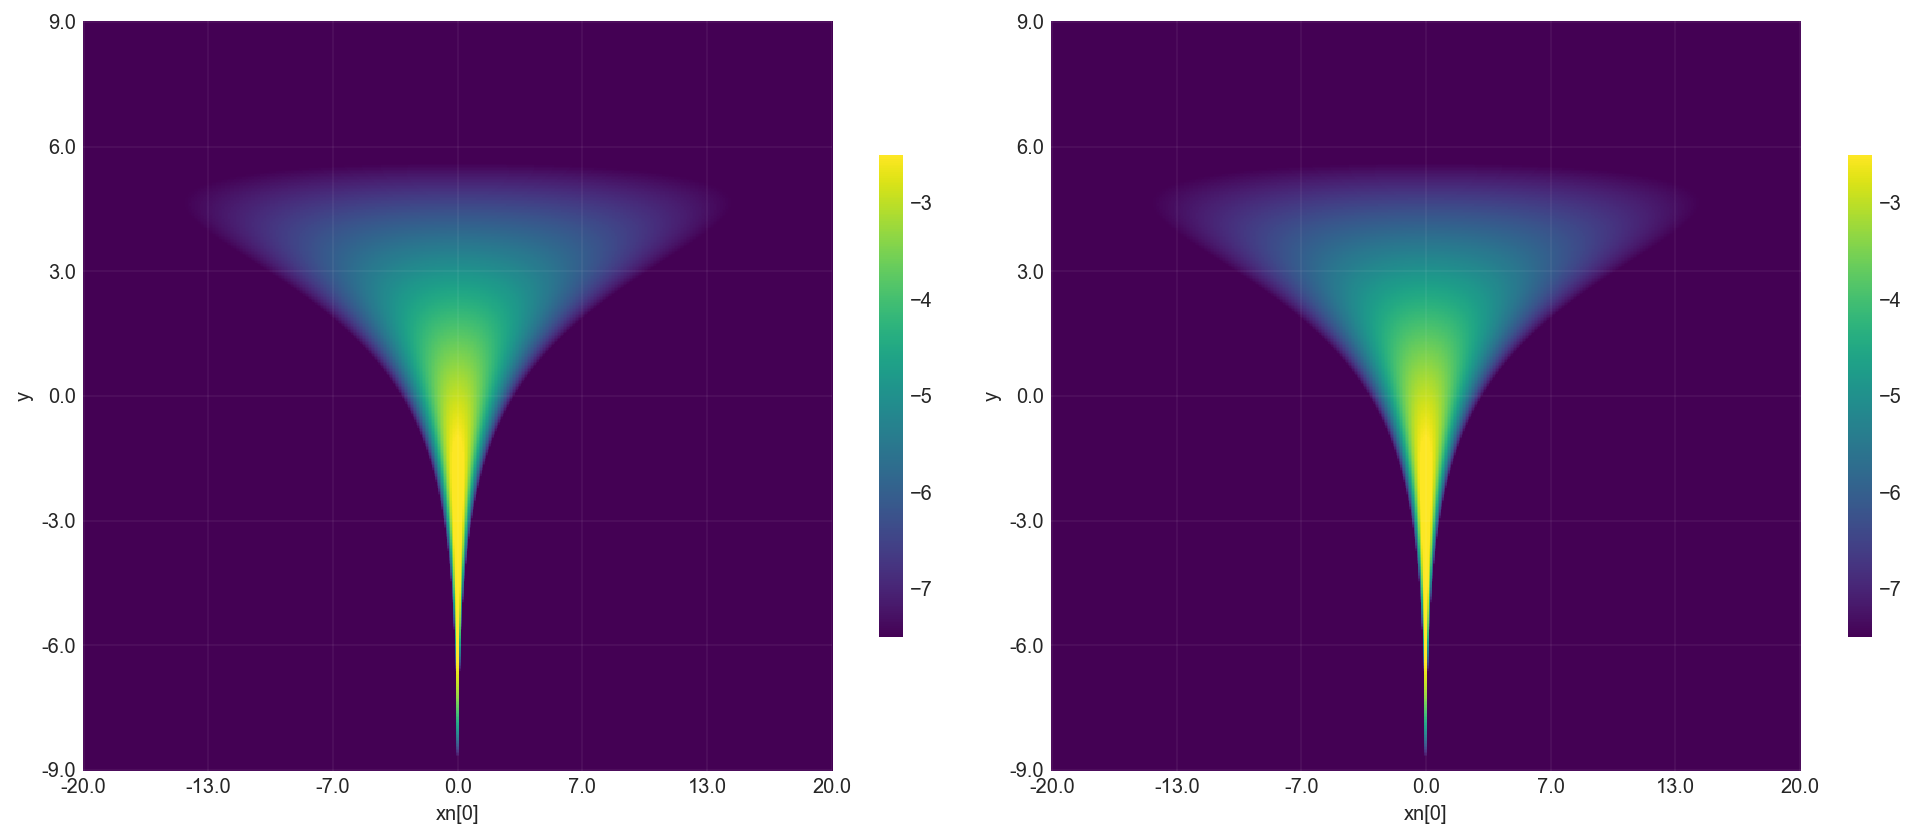

In [24]:
# compute log density
nres = 500
xval = np.linspace(-20, 20, nres)
yval = np.linspace(-9, 9, nres)
xv, yv = np.meshgrid(xval, yval)

# formally it need marginalization if nd > 1
logp_2d = logp_ref1(xv, yv)

logp_2d2 = logp_ref2(xv, yv)

_, ax = plt.subplots(1, 2, figsize=(14, 7))
show_logp2d(logp_2d, ax[0])
show_logp2d(logp_2d2, ax[1])
plt.tight_layout()

In [25]:
y_raw = np.random.randn()
y = 3.*y_raw

np.testing.assert_almost_equal(pm.Normal.dist(mu=0., sd=3.).logp(y).eval(),
                               pm.Normal.dist(mu=0., sd=1.).logp(y_raw).eval() + np.log(1/3))

x_raw = np.random.randn(nd)
x = np.exp(y/2)*x_raw

np.testing.assert_almost_equal(
    pm.Normal.dist(mu=0., sd=np.exp(y/2), shape=nd).logp(x).eval(),
    pm.Normal.dist(mu=0., sd=1., shape=nd).logp(x_raw).eval() +\
                 np.log(np.abs(np.exp(-y/2))))

However, the jacobian determinant is in fact not correct

In [26]:
with m_tran_withjac:
    trace3 = pm.sample(nsample, tune=2000, init='adapt_diag')

divg = trace3.get_sampler_stats('diverging')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 12000/12000 [00:20<00:00, 572.22it/s]


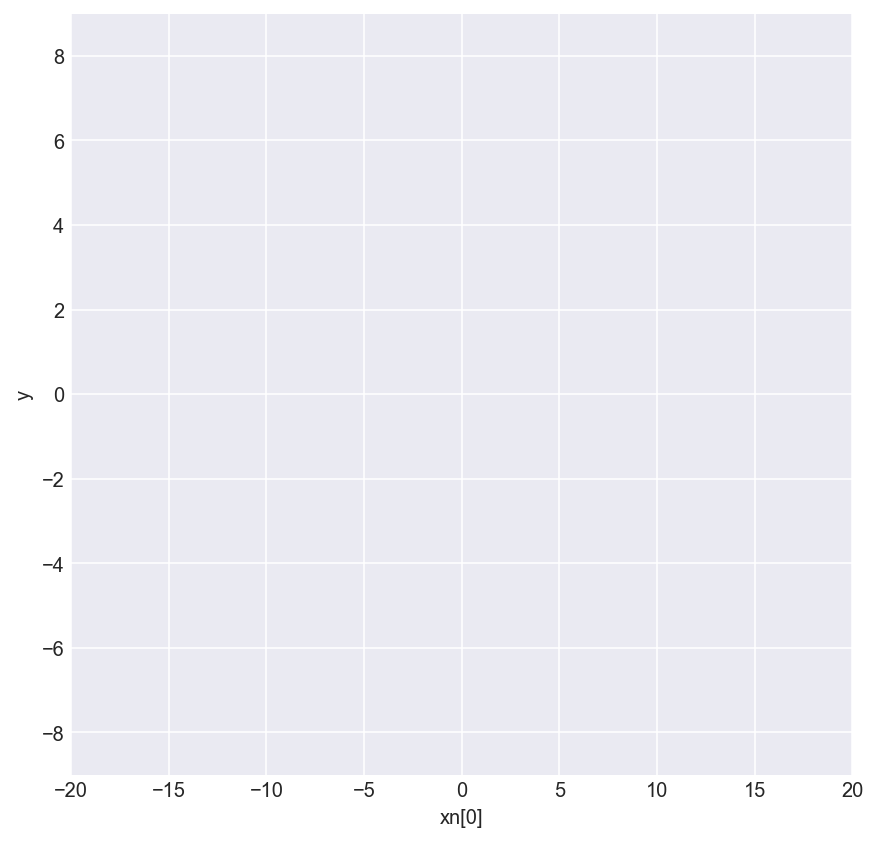

In [27]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace3['x'].T, trace3['y'], ib, ax)
ax.scatter(trace3['x'][divg, ib], trace3['y'][divg], marker='.', color='r', alpha=.1);

In [28]:
func1 = m_tran_withjac.logp_dlogp_function()

In [29]:
func1.set_extra_values(pt)
func1(func1.dict_to_array(inverse_point(pt)))

(array(4.29403186),
 array([-12.19654535,  -0.27464938,  -0.93246887,   1.20676784,
          0.08159758,   0.81921278,  -0.08799663,  -1.0611192 ,
          0.34198766,  -0.02372545]))

In [30]:
func0 = m_raw.logp_dlogp_function()

In [31]:
func0.set_extra_values(pt)
func0(func0.dict_to_array(pt))

(array(4.29403186),
 array([-1.90040379, -1.94045409, -6.58808338,  8.52606173,  0.57650361,
         5.78790591, -0.62171418, -7.49702432,  2.41621283, -0.16762518]))

Different gradient!

In [55]:
from theano.gradient import disconnected_grad as stop_grad
import theano.tensor as tt
import theano

In [56]:
with pm.Model() as m_raw2:
    y = pm.Flat('y')
    x = pm.Flat('x', shape=nd)

    pm.Potential('ypot', pm.Normal.dist(mu=0., sd=3.).logp(y))
    pm.Potential('xpot', pm.Normal.dist(
        mu=0., sd=pm.math.exp(y / 2), shape=nd).logp(x))

$p_Y(y) = p_X(f^{-1}(y)) \mid \mathrm{det} J_{f^{-1}}(y) \mid$

In [57]:
with pm.Model() as m_tran_withjac1:
    y = pm.Flat('y', shape=1)
    x = pm.Flat('x', shape=nd)

    y_inv = y / 3.
    x_inv = x / pm.math.exp(y / 2)

    f_inv = tt.concatenate([x_inv, y_inv], axis=0)
    J, updates = theano.scan(lambda i, f_inv, y1, y2: tt.concatenate(tt.grad(f_inv[i].sum(), [y1, y2]), axis=0),
                             sequences=tt.arange(f_inv.shape[0]),
                             non_sequences=[f_inv, x, y])

    pm.Potential('ypot', pm.Normal.dist(mu=0., sd=1.).logp(y_inv))
    pm.Potential('xpot', pm.Normal.dist(mu=0., sd=1., shape=nd).logp(x_inv))
    pm.Potential('pot', tt.log(tt.abs_(tt.nlinalg.det(J))))

In [58]:
pt['y'] = st.norm.rvs(loc=0., scale=3., size=(1))
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))

In [59]:
func0 = m_raw2.logp_dlogp_function()

In [60]:
func0.set_extra_values(pt)
func0(func0.dict_to_array(pt))

(array(-24.76882067),
 array([-3.33966309, -0.17275108,  0.15025224,  0.13120293,  0.2376122 ,
        -0.04192395,  0.03650901, -0.10915344, -0.16122419,  0.11291233]))

In [61]:
func1 = m_tran_withjac1.logp_dlogp_function()

In [62]:
func1.set_extra_values(pt)
func1(func1.dict_to_array(pt))

(array(-24.76882067),
 array([-3.33966309, -0.17275108,  0.15025224,  0.13120293,  0.2376122 ,
        -0.04192395,  0.03650901, -0.10915344, -0.16122419,  0.11291233]))

In [63]:
from pymc3.distributions.transforms import Transform

class Nealfun(Transform):
    name = "Neal_funnel"

    def backward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0] / 3.)
        x = tt.inc_subtensor(x[1:], y[1:] / tt.exp(y[0] / 2))
        return x

    def forward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0] * 3.)
        y = tt.inc_subtensor(y[1:], tt.exp(x[0] * 3. / 2) * x[1:])
        return y
    
    def jacobian_det(self, x):
        f_inv = self.backward(x)
        J, updates = theano.scan(lambda i, f_inv, x: tt.grad(f_inv[i], x),
                                 sequences=tt.arange(f_inv.shape[0]),
                                 non_sequences=[f_inv, x])
        return tt.log(tt.abs_(tt.nlinalg.det(J)))


def tran_point(pt):
    point = dict()
    point['raw_Neal_funnel__'] = np.concatenate([pt['y'], pt['x']], axis=0)
    return point

In [64]:
with pm.Model() as m_tran_withjac2:
    raw = pm.Normal('raw', mu=0., sd=1., shape=(1+nd),
                    transform=Nealfun(), 
                    testval=np.zeros(1+nd))

func2 = m_tran_withjac2.logp_dlogp_function()
func2.set_extra_values(pt)
func2(func2.dict_to_array(tran_point(pt)))

(array(-24.76882067),
 array([-3.33966309, -0.17275108,  0.15025224,  0.13120293,  0.2376122 ,
        -0.04192395,  0.03650901, -0.10915344, -0.16122419,  0.11291233]))

In [65]:
pt = dict()
pt['y'] = st.norm.rvs(loc=0., scale=3., size=(1))
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))

func0.set_extra_values(pt)
print(func0(func0.dict_to_array(pt)))
func1.set_extra_values(pt)
print(func1(func1.dict_to_array(pt)))
func2.set_extra_values(pt)
print(func2(func2.dict_to_array(tran_point(pt))))

(array(-8.76345028), array([-2.75846844, -0.43490825,  1.74710505,  0.05826123, -0.62881521,
       -1.11643487,  0.25346108, -0.91314519,  0.37602029,  0.93035837]))
(array(-8.76345028), array([-2.75846844, -0.43490825,  1.74710505,  0.05826123, -0.62881521,
       -1.11643487,  0.25346108, -0.91314519,  0.37602029,  0.93035837]))
(array(-8.76345028), array([-2.75846844, -0.43490825,  1.74710505,  0.05826123, -0.62881521,
       -1.11643487,  0.25346108, -0.91314519,  0.37602029,  0.93035837]))


In [70]:
with m_tran_withjac2:
    pm.Deterministic('y', m_tran_withjac2.free_RVs[0][0])
    pm.Deterministic('x', m_tran_withjac2.free_RVs[0][1:])
    
    trace4 = pm.sample(nsample, tune=2000, init='adapt_diag')

divg = trace4.get_sampler_stats('diverging')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [raw_Neal_funnel__]
100%|██████████| 12000/12000 [05:16<00:00, 37.94it/s] 
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5980309306843834, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


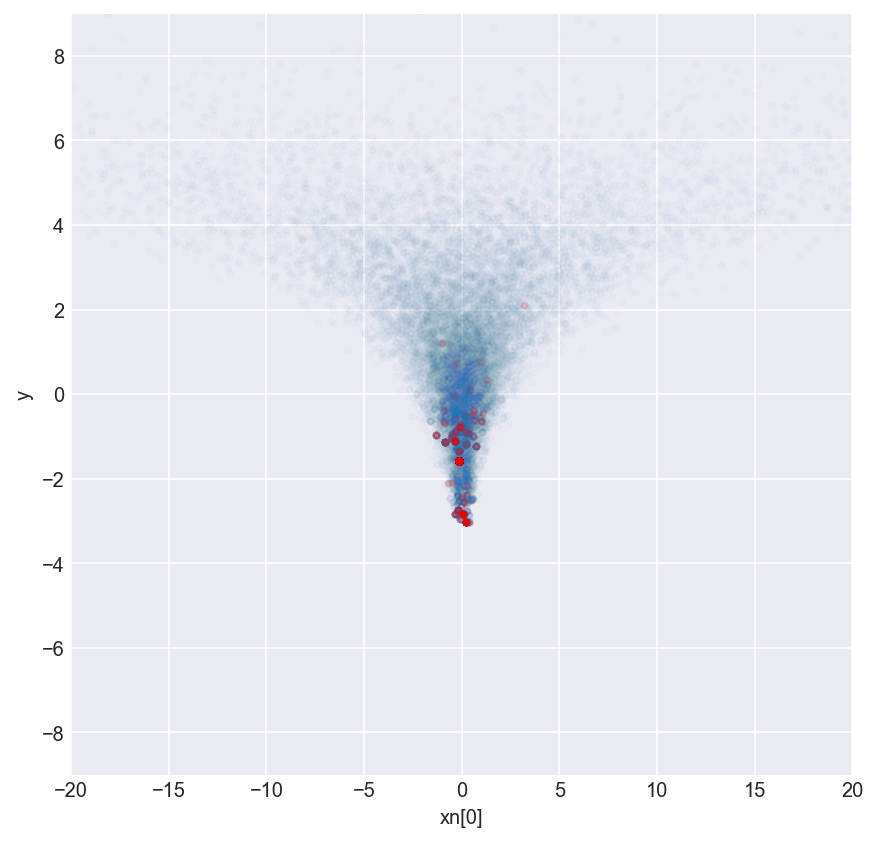

In [71]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace4['x'].T, trace4['y'], ib, ax)
ax.scatter(trace4['x'][divg, ib], trace4['y'][divg], marker='.', color='r', alpha=.1);